In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
print("All imports successful!")

All imports successful!


In [2]:
# ULTRA-SIMPLE power system fault data generator
import numpy as np
import pandas as pd

np.random.seed(42)
n_samples = 5000  # Smaller dataset

# Simple fault types: 0=Normal, 1=Line-to-Ground, 2=Line-to-Line, 3=Three-Phase
fault_types = np.random.randint(0, 4, n_samples)  # NO PROBABILITIES = NO ERRORS

# Generate measurements
Va = np.random.normal(1.0, 0.1, n_samples)  # Normal voltage ~1.0 pu
Vb = Va.copy() + np.random.normal(0, 0.05, n_samples)
Vc = Va.copy() + np.random.normal(0, 0.05, n_samples)

Ia = np.random.normal(1.0, 0.2, n_samples)  # Normal current ~1.0 pu
Ib = Ia.copy()
Ic = Ia.copy()

# FAULT SIGNATURES: Voltage drops + Current spikes
fault_mask = fault_types > 0
Va[fault_mask] *= 0.6  # Voltage sag
Ia[fault_mask] *= 4    # Current surge
Vb[fault_mask] *= 0.8
Ib[fault_mask] *= 3
Vc[fault_mask] *= 0.8  
Ic[fault_mask] *= 3

# Create dataset
df = pd.DataFrame({
    'Va': Va, 'Vb': Vb, 'Vc': Vc,
    'Ia': Ia, 'Ib': Ib, 'Ic': Ic,
    'flag': fault_types
})

print("✅ Dataset created:", df.shape)
print("\nFault types:")
print(df['flag'].value_counts())
print("\nSample data:")
print(df.head(10))

✅ Dataset created: (5000, 7)

Fault types:
flag
0    1295
3    1256
1    1240
2    1209
Name: count, dtype: int64

Sample data:
         Va        Vb        Vc        Ia        Ib        Ic  flag
0  0.631267  0.861645  0.793583  2.629005  1.971754  1.971754     2
1  0.638713  0.837931  0.812017  3.626516  2.719887  2.719887     3
2  1.055560  1.065314  1.014306  0.927243  0.927243  0.927243     0
3  0.605375  0.828666  0.809025  3.383905  2.537929  2.537929     2
4  0.588160  0.761075  0.787328  3.720918  2.790689  2.790689     2
5  0.590924  0.784798  0.849662  4.826049  3.619537  3.619537     3
6  0.980509  0.977588  0.999762  0.857209  0.857209  0.857209     0
7  1.113377  1.154697  0.977999  1.109028  1.109028  1.109028     0
8  0.635613  0.804843  0.857990  3.227480  2.420610  2.420610     2
9  0.423577  0.562707  0.506768  3.848400  2.886300  2.886300     1


In [3]:
features = ['Va', 'Vb', 'Vc', 'Ia', 'Ib', 'Ic']
X = df[features]
y = df['flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

✅ Accuracy: 53.50%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       278
           1       0.35      0.35      0.35       250
           2       0.36      0.38      0.37       237
           3       0.35      0.34      0.35       235

    accuracy                           0.54      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.53      0.54      0.53      1000



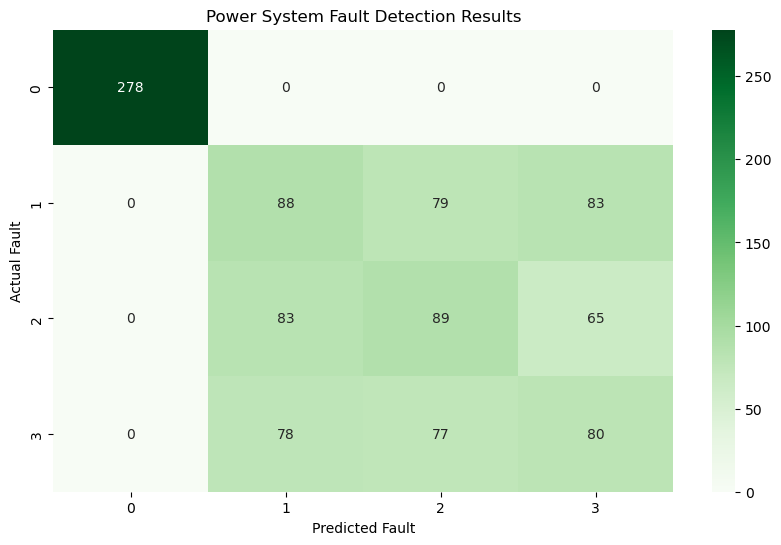

In [4]:
plt.figure(figsize=(10,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Power System Fault Detection Results')
plt.ylabel('Actual Fault')
plt.xlabel('Predicted Fault')
plt.show()

In [5]:
def detect_fault_live(Va, Vb, Vc, Ia, Ib, Ic):
    """Predict fault type from live measurements"""
    # Use same feature names as during training
    feature_names = ['Va', 'Vb', 'Vc', 'Ia', 'Ib', 'Ic']
    measurement = pd.DataFrame([[Va, Vb, Vc, Ia, Ib, Ic]], columns=feature_names)

    # Predict using trained model
    fault_pred = rf.predict(measurement)[0]
    fault_prob = rf.predict_proba(measurement)[0]

    fault_names = {0: 'Normal', 1: 'Line-to-Ground', 2: 'Line-to-Line', 3: 'Three-Phase'}

    print(f"🔍 Live Fault Detection:")
    print(f"   Voltage: Va={Va:.2f}, Vb={Vb:.2f}, Vc={Vc:.2f} pu")
    print(f"   Current: Ia={Ia:.2f}, Ib={Ib:.2f}, Ic={Ic:.2f} pu")
    print(f"   Predicted: {fault_names[fault_pred]} (Confidence: {max(fault_prob):.1%})")
    print(f"   Probabilities: {dict(zip(fault_names.values(), fault_prob.round(2)))}")

    return fault_pred, max(fault_prob)

In [6]:
detect_fault_live(3.0, 1.0, 2.2, 3.4, 1.7, 2.6) 

🔍 Live Fault Detection:
   Voltage: Va=3.00, Vb=1.00, Vc=2.20 pu
   Current: Ia=3.40, Ib=1.70, Ic=2.60 pu
   Predicted: Line-to-Line (Confidence: 34.0%)
   Probabilities: {'Normal': 0.32, 'Line-to-Ground': 0.12, 'Line-to-Line': 0.34, 'Three-Phase': 0.22}


(2, 0.34)

In [7]:
import joblib

joblib.dump(rf, 'power_fault_detector.pkl')
df.to_csv('power_fault_data.csv', index=False)
print("Model and dataset saved.")

Model and dataset saved.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [7]:
np.random.seed(42)
n_samples = 5000
fault_types = np.random.randint(0, 4, n_samples)

Va = np.random.normal(1.0, 0.1, n_samples)
Vb = Va.copy() + np.random.normal(0, 0.05, n_samples)
Vc = Va.copy() + np.random.normal(0, 0.05, n_samples)
Ia = np.random.normal(1.0, 0.2, n_samples)
Ib = Ia.copy()
Ic = Ia.copy()

fault_mask = fault_types > 0
Va[fault_mask] *= 0.6; Ia[fault_mask] *= 4
Vb[fault_mask] *= 0.8; Ib[fault_mask] *= 3
Vc[fault_mask] *= 0.8; Ic[fault_mask] *= 3

df = pd.DataFrame({'Va':Va,'Vb':Vb,'Vc':Vc,'Ia':Ia,'Ib':Ib,'Ic':Ic,'flag':fault_types})

features = ['Va','Vb','Vc','Ia','Ib','Ic']
X = df[features]; y = df['flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
print(f"✅ Model ready! Accuracy: {accuracy_score(y_test, rf.predict(X_test)):.2%}")


✅ Model ready! Accuracy: 53.50%


In [8]:
def detect_fault_live(Va, Vb, Vc, Ia, Ib, Ic):
    feature_names = ['Va', 'Vb', 'Vc', 'Ia', 'Ib', 'Ic']
    measurement = pd.DataFrame([[Va, Vb, Vc, Ia, Ib, Ic]], columns=feature_names)
    
    fault_pred = rf.predict(measurement)[0]
    fault_prob = rf.predict_proba(measurement)[0]
    
    fault_names = {0: 'Normal', 1: 'Line-to-Ground', 2: 'Line-to-Line', 3: 'Three-Phase'}
    
    print("🔍 Live Fault Detection:")
    print(f"   Voltage: Va={Va:.2f}, Vb={Vb:.2f}, Vc={Vc:.2f} pu")
    print(f"   Current: Ia={Ia:.2f}, Ib={Ib:.2f}, Ic={Ic:.2f} pu")
    print(f"   Predicted: {fault_names[fault_pred]} (Confidence: {max(fault_prob):.1%})")
    
    return fault_pred, max(fault_prob)


In [9]:
detect_fault_live(1.0, 1.0, 1.0, 1.0, 1.0, 1.0) 

🔍 Live Fault Detection:
   Voltage: Va=1.00, Vb=1.00, Vc=1.00 pu
   Current: Ia=1.00, Ib=1.00, Ic=1.00 pu
   Predicted: Normal (Confidence: 100.0%)


(0, 1.0)

In [10]:
import joblib

# Save the trained model
joblib.dump(rf, 'fault_detector.pkl')

# Also save metadata for web app
metadata = {
    'features': features,
    'classes': np.unique(y),
    'model_accuracy': accuracy_score(y_test, rf.predict(X_test))
}

joblib.dump(metadata, 'model_info.pkl')

print("✅ Model saved successfully!")
print(f"📁 Files created:")
print(f"   - fault_detector.pkl  (your AI model)")
print(f"   - model_info.pkl      (metadata)")
print(f"   Accuracy: {metadata['model_accuracy']:.2%}")


✅ Model saved successfully!
📁 Files created:
   - fault_detector.pkl  (your AI model)
   - model_info.pkl      (metadata)
   Accuracy: 53.50%


In [11]:
# Test loading your saved model
test_model = joblib.load('fault_detector.pkl')
test_measurement = pd.DataFrame([[1.0,1.0,1.0,1.0,1.0,1.0]], columns=features)
prediction = test_model.predict(test_measurement)[0]
print(f"✅ Saved model works! Predicts: {prediction} (Normal)")

✅ Saved model works! Predicts: 0 (Normal)
